In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
def update_parameters_with_gd(parameters, grads, learning_rate) :
    
    L = len(parameters) // 2
    
    for l in range(1, L + 1) :
        parameters['W' + str(l)] = parameters['W' + str(l)] - learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] = parameters['b' + str(l)] - learning_rate * grads['db' + str(l)]
        
    return parameters

In [3]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0) :
    
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    num_complete_minibatches = m // mini_batch_size
    
    for k in range(num_complete_minibatches) :
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    if m % mini_batch_size != 0 :
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size :]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size :]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches

In [4]:
def initialize_velocity(parameters) :
    
    L = len(parameters) // 2
    v = {}
    
    for l in range(1, L + 1) :
        v['dW' + str(l)] = np.zeros_like(parameters['W' + str(l)])
        v['db' + str(l)] = np.zeros_like(parameters['b' + str(l)])
        
    return v

In [5]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate) :
    
    L = len(parameters) // 2
    
    for l in range(1, L + 1) :
        v['dW' + str(l)] = beta * v['dW' + str(l)] + (1 - beta) * grads['dW' + str(l)]
        v['db' + str(l)] = beta * v['db' + str(l)] + (1 - beta) * grads['db' + str(l)]
        
        parameters['W' + str(l)] = parameters['W' + str(l)] - learning_rate * v['dW' + str(l)]
        parameters['b' + str(l)] = parameters['b' + str(l)] - learning_rate * v['db' + str(l)]
        
    return parameters, v

In [7]:
def initialize_adam(parameters) :
    
    L = len(parameters) // 2
    v = {}
    s = {}
    
    for l in range(1, L + 1) :
        v['dW' + str(l)] = np.zeros_like(parameters['W' + str(l)])
        v['db' + str(l)] = np.zeros_like(parameters['b' + str(l)])
        s['dW' + str(l)] = np.zeros_like(parameters['W' + str(l)])
        s['db' + str(l)] = np.zeros_like(parameters['b' + str(l)])
        
    return v, s

In [8]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8) :
    
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}
    
    for l in range(1, L + 1) :
        v['dW' + str(l)] = beta1 * v['dW' + str(l)] + (1 - beta1) * grads['dW' + str(l)]
        v['db' + str(l)] = beta1 * v['db' + str(l)] + (1 - beta1) * grads['db' + str(l)]
        
        v_corrected['dW' + str(l)] = v['dW' + str(l)] / (1 - beta1 ** t)
        v_corrected['db' + str(l)] = v['db' + str(l)] / (1 - beta1 ** t)
        
        s['dW' + str(l)] = beta2 * s['dW' + str(l)] + (1 - beta2) * grads['dW' + str(l)] ** 2
        s['db' + str(l)] = beta2 * s['db' + str(l)] + (1 - beta2) * grads['db' + str(l)] ** 2
        
        s_corrected['dW' + str(l)] = s['dW' + str(l)] / (1 - beta2 ** t)
        s_corrected['db' + str(l)] = s['db' + str(l)] / (1 - beta2 ** t)
        
        parameters['W' + str(l)] = parameters['W' + str(l)] - learning_rate * v_corrected['dW' + str(l)] / (np.sqrt(s_corrected['dW' + str(l)]) + epsilon)
        parameters['b' + str(l)] = parameters['b' + str(l)] - learning_rate * v_corrected['db' + str(l)] / (np.sqrt(s_corrected['db' + str(l)]) + epsilon)
        
    return parameters, v, s

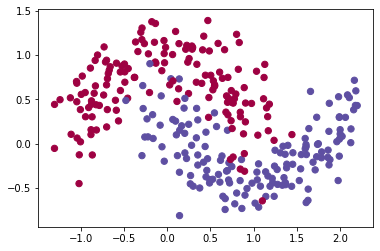

In [9]:
train_X, train_Y = load_dataset()

In [10]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9, beta1 = 0.9, beta2 = 0.99, 
          epsilon = 1e-8, num_epochs = 10000, print_cost = True) :
    
    L = len(layers_dims)
    costs = []
    t = 0
    seed = 10
    m = X.shape[1]
    
    parameters = initialize_parameters(layers_dims)
    
    if optimizer == 'gd' :
        pass
    elif optimizer == 'momentum' :
        v = initialize_velocity(parameters)
    elif optimizer == 'adam' :
        v, s = initialize_adam(parameters)
        
    for i in range(num_epochs) :
        
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches :
            
            (minibatch_X, minibatch_Y) = minibatch
            
            a3, caches = forward_propagation(minibatch_X, parameters)
            
            cost_total += compute_cost(a3, minibatch_Y)
            
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)
            
            if optimizer == 'gd' :
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == 'momentum' :
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == 'adam' :
                t = t + 1    # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)
                
        cost_avg = cost_total / m
        
        if print_cost and i % 1000 == 0 :
            print(f"Cost after epoch {i} : {cost_avg}")
        if print_cost and i % 100 == 0 :
            costs.append(cost_avg)
            
    plt.plot(costs)
    plt.ylabel('Cost')
    plt.xlabel('epochs (per 100)')
    plt.title('Learning rate = ' + str(learning_rate))
    plt.show()
    
    return parameters

Cost after epoch 0 : 0.7024046849828726
Cost after epoch 1000 : 0.66810064295887
Cost after epoch 2000 : 0.6352875703390978
Cost after epoch 3000 : 0.600491198436302
Cost after epoch 4000 : 0.5733672256957693
Cost after epoch 5000 : 0.5519772083453836
Cost after epoch 6000 : 0.5323695140170054
Cost after epoch 7000 : 0.5140067717007158
Cost after epoch 8000 : 0.4964720510901485
Cost after epoch 9000 : 0.4680136839007519


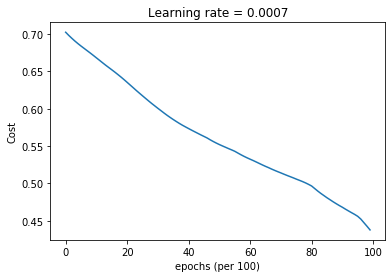

Accuracy: 0.7966666666666666


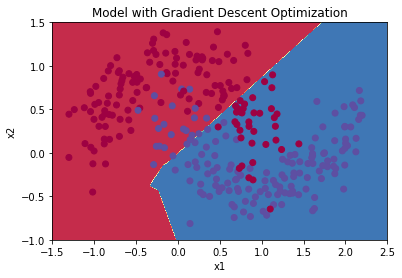

In [12]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = 'gd')

predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Gradient Descent Optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x : predict_dec(parameters, x.T), train_X, train_Y[0, :])

Cost after epoch 0 : 0.7024127305373173
Cost after epoch 1000 : 0.6681667772046954
Cost after epoch 2000 : 0.6353882166761965
Cost after epoch 3000 : 0.6005907762003798
Cost after epoch 4000 : 0.5734441760375261
Cost after epoch 5000 : 0.5520579978012191
Cost after epoch 6000 : 0.532458404673331
Cost after epoch 7000 : 0.5141006579460334
Cost after epoch 8000 : 0.49665208993936555
Cost after epoch 9000 : 0.46815966712698187


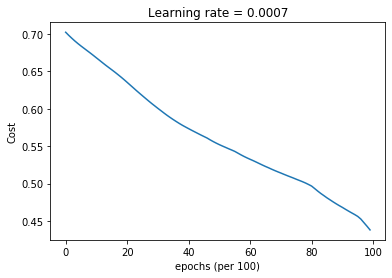

Accuracy: 0.7966666666666666


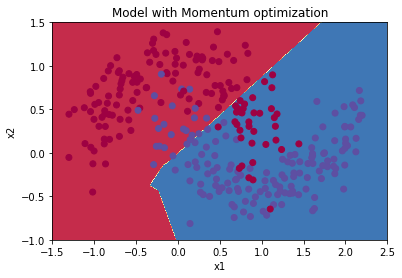

In [14]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = 'momentum')

predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y[0, :])

Cost after epoch 0 : 0.7021653519066937
Cost after epoch 1000 : 0.16154102540037615
Cost after epoch 2000 : 0.140212343158064
Cost after epoch 3000 : 0.13703121648661606
Cost after epoch 4000 : 0.1346110628906301
Cost after epoch 5000 : 0.13188274590603835
Cost after epoch 6000 : 0.1307159410545635
Cost after epoch 7000 : 0.13005942528412356
Cost after epoch 8000 : 0.1295239086715807
Cost after epoch 9000 : 0.12907709060215172


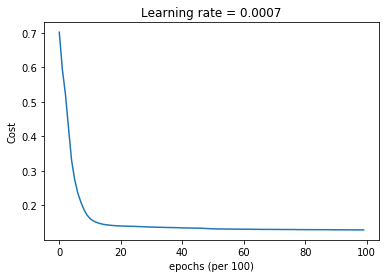

Accuracy: 0.94


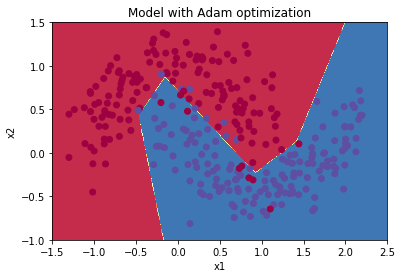

In [16]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y[0, :])